Zmiany w stosunku do dokumentacji wstępnej:
* zmiana oceny jakości za pomocą krzywej PR na krzywą ROC, ponieważ biblioteka sklearn wspiera tą metodę w wersji wieloklasowej

In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from bagging_classifier import CustomBaggingClassifier
from datasets import load_dataset
from tqdm import tqdm

In [143]:
X, y, numerical_columns, categorical_columns, label_encoder = load_dataset(name="wine")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Rozkład klas

w przypadku zbioru danych wine usuwane są 2 najmniej liczne klasy (5 próbek i 30 próbek) ponieważ jest to zbyt mało, żeby się dobrze nauczyć i zaburzałyby uśredniania.

In [130]:
unique, counts = np.unique(y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0  216]
 [   1 2138]
 [   2 2836]
 [   3 1079]
 [   4  193]]


In [213]:
def get_k_fold_metrics(model, splits, X, y):
    cv = StratifiedKFold(n_splits=splits, random_state=0, shuffle=True)
    micro_f1_all = []
    macro_f1_all = []
    micro_auc_all = []
    macro_auc_all = []
    for fold, (train, test) in enumerate(cv.split(X, y)):
        X_train = X.iloc[train]
        X_test = X.iloc[test]
        y_train = y.iloc[train]
        y_test = y.iloc[test]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict(X_test, predict_proba=True)

        micro_f1 = f1_score(y_test.values.squeeze(1), y_pred, average='micro')
        macro_f1 = f1_score(y_test.values.squeeze(1), y_pred, average='macro')
        micro_auc = roc_auc_score(y_test.values.squeeze(1), y_pred_proba, multi_class='ovr', average='micro')
        macro_auc = roc_auc_score(y_test.values.squeeze(1), y_pred_proba, multi_class='ovr', average='macro')
        micro_f1_all.append(micro_f1)
        macro_f1_all.append(macro_f1)
        macro_auc_all.append(macro_auc)
        micro_auc_all.append(micro_auc)

    total_micro_auc = sum(micro_auc_all) / splits
    total_macro_auc = sum(macro_auc_all) / splits
    total_micro_f1 = sum(micro_f1_all) / splits
    total_macro_f1 = sum(macro_f1_all) / splits
    return pd.DataFrame.from_dict(data=[{'total_micro_auc': total_micro_auc,
                         'total_macro_auc': total_macro_auc,
                         'total_micro_f1': total_micro_f1,
                         'total_macro_f1': total_macro_f1,
                         'sum': total_micro_auc + total_macro_auc + total_micro_f1 + total_macro_f1}])

def get_train_test_metrics(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict(x_test, predict_proba=True)

    micro_f1 = f1_score(y_test.values.squeeze(1), y_pred, average='micro')
    macro_f1 = f1_score(y_test.values.squeeze(1), y_pred, average='macro')
    micro_auc = roc_auc_score(y_test.values.squeeze(1), y_pred_proba, multi_class='ovr', average='micro')
    macro_auc = roc_auc_score(y_test.values.squeeze(1), y_pred_proba, multi_class='ovr', average='macro')

    return pd.DataFrame.from_dict(data=[{'total_micro_auc': micro_auc,
                         'total_macro_auc': macro_auc,
                         'total_micro_f1': micro_f1,
                         'total_macro_f1': macro_f1,
                         'sum': micro_auc + macro_auc + micro_f1 + macro_f1}])

In [137]:
grid = [{'loss': ['hinge', 'squared_hinge'], 'C': [0.01, 0.1, 1, 10, 100, 1000]}]
sklearn_grid = ParameterGrid(grid)
total_metrics = pd.DataFrame()

for param_grid in tqdm(sklearn_grid):
    model = CustomBaggingClassifier(estimator=LinearSVC,
                                    sample_size=1,
                                    sample_size_features=1,
                                    sampling_with_replacement_features=False,
                                    sampling_with_replacement=True,
                                    n_estimators=10,
                                    categorical_features=categorical_columns,
                                    estimator_kwargs=param_grid)
    metrics = get_k_fold_metrics(model, splits=5, X=X, y=y)
    row = pd.concat([pd.DataFrame([param_grid]), metrics], axis=1)
    total_metrics = pd.concat([total_metrics, row])

100%|██████████| 12/12 [05:02<00:00, 25.23s/it]


In [138]:
total_metrics.sort_values(by='sum')

,C,loss,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,10.00,hinge,0.683383,0.571060,0.439045,0.199222,1.892710
0,0.01,hinge,0.703895,0.558570,0.460406,0.203785,1.926655
0,0.10,hinge,0.701888,0.583568,0.443687,0.205315,1.934457
0,1.00,hinge,0.705582,0.575339,0.460253,0.210370,1.951543
0,0.01,squared_hinge,0.708721,0.561135,0.493829,0.232066,1.995751
0,10.00,squared_hinge,0.709623,0.561784,0.494141,0.235486,2.001035
0,0.10,squared_hinge,0.709579,0.561665,0.495222,0.235663,2.002130
0,1.00,squared_hinge,0.710264,0.562574,0.495842,0.237048,2.005727
0,100.00,hinge,0.774637,0.602369,0.482374,0.226310,2.085690
0,1000.00,squared_hinge,0.789888,0.604610,0.472007,0.219403,2.085909


Wybrany model dla parametrów loss=squared_hinge, C=100

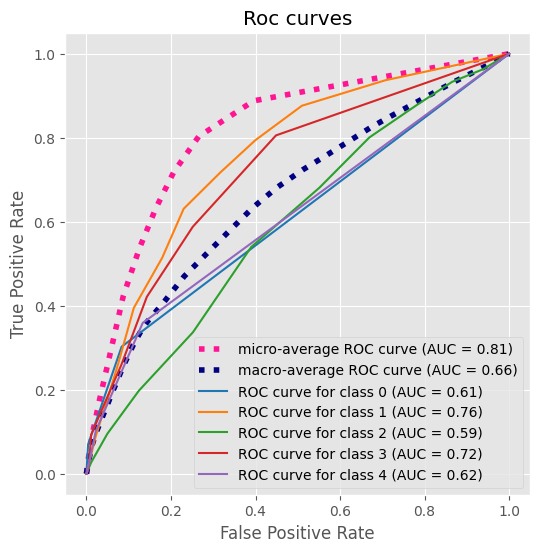

In [190]:
from plot_roc import plot_roc
model = CustomBaggingClassifier(estimator=LinearSVC,
                        sample_size=1,
                        sample_size_features=1,
                        sampling_with_replacement_features=False,
                        sampling_with_replacement=True,
                        n_estimators=10,
                        categorical_features=categorical_columns,
                        estimator_kwargs={'loss': 'squared_hinge', 'C': 100})
model.fit(X_train, y_train)
y_pred = model.predict(X_test, predict_proba=True)
plot_roc(y_pred, y_test, model.n_classes)

Wpływ liczby modeli w zespole na wyniki klasyfikacji dla modelu SVM i zbioru danych Wine Quality

In [214]:
total_metrics = pd.DataFrame()
n_estimators_arr = [1,5,10,20,50,100,200]
for n_estimators in tqdm(n_estimators_arr):
    model = CustomBaggingClassifier(estimator=LinearSVC,
                            sample_size=1,
                            sample_size_features=1,
                            sampling_with_replacement_features=False,
                            sampling_with_replacement=True,
                            n_estimators=n_estimators,
                            categorical_features=categorical_columns,
                            estimator_kwargs={'loss': 'hinge', 'C': 1000})
    metrics = get_train_test_metrics(model, X_train, X_test, y_train, y_test)
    total_metrics = pd.concat([total_metrics, metrics])

100%|██████████| 7/7 [05:36<00:00, 48.04s/it]


(0.0, 1.0)

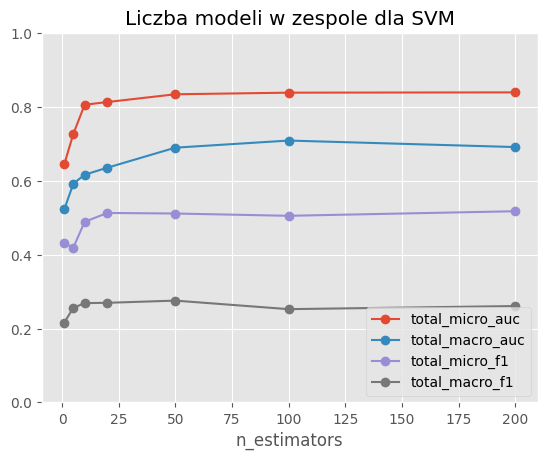

In [215]:
plt.figure()
for metric in ['total_micro_auc','total_macro_auc','total_micro_f1','total_macro_f1']:
    plt.plot(n_estimators_arr, total_metrics[metric], '-o', label=metric)
plt.legend(loc='best')
plt.xlabel("n_estimators")
plt.title("Liczba modeli w zespole dla SVM")
plt.ylim([0,1])